# Generate Training Data

In order to train the discriminative models, we need training data. To this end, we create synthetic training data via a simple simulation of kicks on goal. The algorithm works as follows:

- Sample a position (i.e. $x \in [0, 1]$ and $y \in [0, 2]$)
- Sample from one of the possible ranges `{wide-left`, `block-left`, `block-center`, `block-right`, `wide-right}`
- Sample from one the possible powers `{weak`, `strong}`
- Kick!
- Record each sample

### 1D Deterministic Data Generator

In [23]:
TIME_STEPS = 200
DECAY = .996

label
0    1200
1    1800
dtype: int64

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


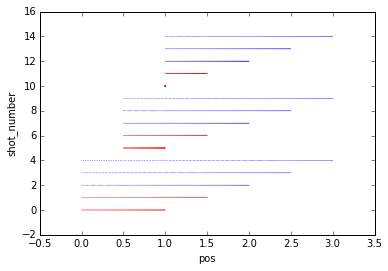

In [24]:
import math
import random

import itertools
from collections import namedtuple

State = namedtuple('State', ['shot_number', 'pos', 'vel', 'label'])
World = namedtuple('World', ['goal', 'end'])

def data_generator(num_starts=3, num_ends=5, time_steps=10, decay=.8):
    """Generate data from a fixed set of grid points
    
    Parameters
    ----------
    num_starts : int
    The number of starting points you want
    
    num_ends : int
    The number of ending points you want
    
    time_steps : int
    The number of time steps for the ball to get to the robot. This number should be calculated based on
    the assumption that we're operating at 50 Hz. A reasonable number of time steps would thus be 100 (2 seconds)
    
    decay : float
    The constant decay rate of the velocity of the ball
    
    """    
    # Starting and ending points
    starts, ends = np.linspace(0, 1, num_starts), np.linspace(1, 3, num_ends)
    
    for shot_number, (start, end) in enumerate(itertools.product(starts, ends)):
        label = 1 if end >= 2 else 0
        
        # Starting velocities to reach the goal
        c = (1-decay) / (1-decay**(time_steps-1))
        dstart = c * (end-start)

        # Calculate how far you've traveled from the start at each time_step
        decays = np.array([decay**pow for pow in range(time_steps)])

        # Velocity at each time step
        velocities = decays * dstart

        # Distance traveled at each time step
        deltas = np.cumsum(velocities)

        # Compute the actual points given distances
        positions = start + deltas
        positions = np.append([start], positions[:-1])
        
        # Yield the points one by one
        for position, velocity in zip(positions, velocities):
            yield State(shot_number, position, velocity, label)


# Generate shot data
data_points = data_generator(num_starts=3, num_ends=5, time_steps=TIME_STEPS, decay=DECAY)
data_points = list(data_points)

# Plot it
%matplotlib inline
df = pd.DataFrame(data_points, columns=State._fields)
labels = df['label']
colormap = np.array(['r', 'b'])
axes = df.plot(kind='scatter', x='pos', y='shot_number', c=colormap[labels], s=0)
axes.quiver(df['pos'], df['shot_number'], df['vel'], np.zeros_like(df['vel']), color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, width=.0022)

df.groupby('label').size()

### Filter Away Invisible Points

In [25]:
data_points = [data_point for data_point in data_points if data_point.pos <= 2]

data_points_1d = pd.DataFrame(data_points, columns=State._fields)
 
data_points_1d.groupby('label').size()

label
0    1200
1    1286
dtype: int64

### Restore Class Balance

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


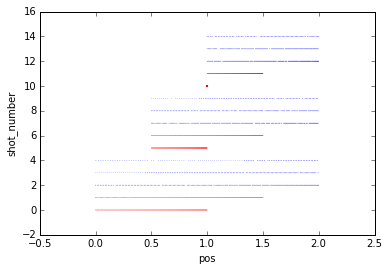

In [26]:
groups = data_points_1d.groupby('label')
max_size = groups.size().min()

def filter_down(group):
    """Filters down a pandas groupby object to a specified number"""
    
    size = len(group)
    mask = np.full(size, False, bool)
    lucky_indices = np.random.choice(size, max_size, replace=False)
    mask[lucky_indices] = True
    
    return group[mask]

balanced_data_1d = groups.apply(filter_down)
df = balanced_data_1d

# Plot it
labels = df['label']
colormap = np.array(['r', 'b'])
axes = df.plot(kind='scatter', x='pos', y='shot_number', c=colormap[labels], s=0)
axes.quiver(df['pos'], df['shot_number'], df['vel'], np.zeros_like(df['vel']), color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, width=.0022)

### Helper Functions

In [27]:
def windowize(X, window_size):
    """Takes a 1darray and windowizes it
    
    Parameters
    ----------
    X : numpy array
    the data you want to windowize
    
    window_size : int
    the size of the window you want
    
    """
    for i in range(window_size-1):
        yield X[i:-(window_size-i-1)]

    yield X[window_size-1:]

def windowize_wrapper(col_name, group):
    """Windowizes a pandas groupby object
    
    - Extract the column specified by col_name
    - Pass it to windowize()
    - Stack the result and return
    
    """
    positions = np.array(group[col_name])
    windowed = list(windowize(positions, WINDOW_SIZE))
    
    return np.vstack(windowed)

### Windowize Input

In [28]:
WINDOW_SIZE = 10

In [29]:
data_1d = balanced_data_1d
data_1d.index = data_1d.index.droplevel(0)

grouped = data_1d.groupby('shot_number')

In [30]:
from functools import partial

# Position
wr = partial(windowize_wrapper, 'pos')
positions = np.hstack(grouped.apply(wr))

# Velocity
wr = partial(windowize_wrapper, 'vel')
velocities = np.hstack(grouped.apply(wr))

# Shot number
wr = partial(windowize_wrapper, 'shot_number')
shot_numbers = np.hstack([shot_sequence.mean(axis=0) for shot_sequence in grouped.apply(wr)])

# Labels
wr = partial(windowize_wrapper, 'label')
labels = np.hstack([label_sequence.mean(axis=0) for label_sequence in grouped.apply(wr)])

stacked = np.vstack([positions] + [velocities])
df1 = pd.DataFrame(stacked.T, columns=[*['pos{}'.format(i) for i in range(WINDOW_SIZE)], *['vel{}'.format(i) for i in range(WINDOW_SIZE)]])

# Compute average positions and velocities for plotting
df1['pos_avg'] = df1.ix[:, 'pos0':'pos9'].mean(axis=1)
df1['vel_avg'] = df1.ix[:, 'vel0':'vel9'].mean(axis=1)

stacked = np.vstack([shot_numbers] + [labels])
df2 = pd.DataFrame(stacked.T, columns=['shot_number', 'label'])

data_1d = pd.concat([df1, df2], axis=1)

In [31]:
%store data_1d

Stored 'data_1d' (DataFrame)
